# Python Implementation of the Ising Model

Implemented By: Tyler Biggs

## Other Guides and References

This is not a totally new implementation, it has been done a number of times before.
See the resources below.

- [A python implementation](http://rajeshrinet.github.io/blog/2014/ising-model/)
- [Another Python implementation](https://github.com/bdhammel/Ising-Model/blob/master/ising.py)
- [A detailed paper](https://arxiv.org/pdf/0803.0217.pdf)

## Introduction

Ising models concern simulating magnetic dipoles of atoms.
The core idea in exporing this phenomena of *energy minimization*
and *entropy maximization*. The temperature of a given
system controlls which of these effects dominates.

### Boltzmann Probability Distribution

You have surely seen this before. Let us import our Python
packages and plot it to get ready.

$$
P(\alpha) = e^{\frac{-E(\alpha)}{kT}}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

### Define Constants

In [2]:
# It is tempting but BAD PRACTICE to use 'k' and other
# such short cuts.
boltzmann_constant = {
    'J_per_kelvin': np.float(1.38064852e-23),
    'eV_per_kelvin':     np.float(8.6173303e-5),
    'erg_per_kelvin':    np.float(1.38064852e-16),
}

### Define the Boltzmann Distribution Probability Function

In [3]:
def calc_Boltz_Dist_Prob(energy, temperature, k=1.0):
    """Returns the probability of a given energy. This function
    defaults to a unitless output."""
    return np.exp(-energy / (k * temperature))

In [4]:
# Create ranges of temperature and energy.
temp_range = np.arange(0.1, 100)
energy_range = np.arange(0.1, 100)

In [5]:
# Create a mesh grid of these points so that we can
# visualize this function in three dimensions.
temp_mesh, energy_mesh = np.meshgrid(temp_range, energy_range)

# Calculate the Boltzmann Mesh
boltz_mesh = calc_Boltz_Dist_Prob(temp_mesh, energy_mesh)

### Plot the Boltzmann Distribution

<IPython.core.display.Javascript object>


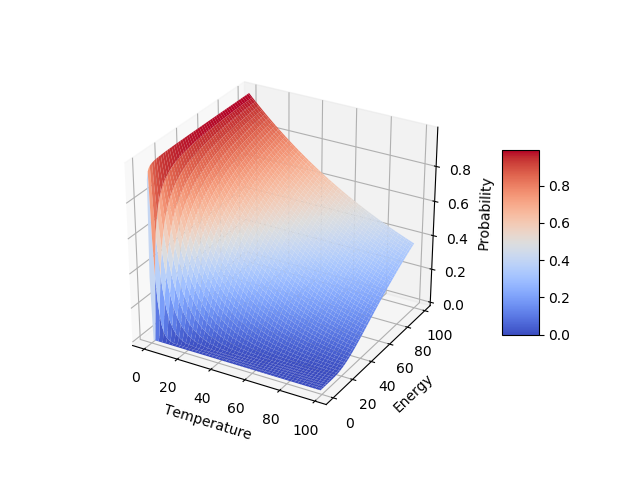

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(
    temp_mesh, 
    energy_mesh, 
    boltz_mesh,
    cmap=matplotlib.cm.coolwarm,
)

ax.set_xlabel('Temperature')
ax.set_ylabel('Energy')
ax.set_zlabel('Probability')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Generate an image from the Boltzmann Mesh

I wonder if this could be used to display our implemented Ising model...

<IPython.core.display.Javascript object>


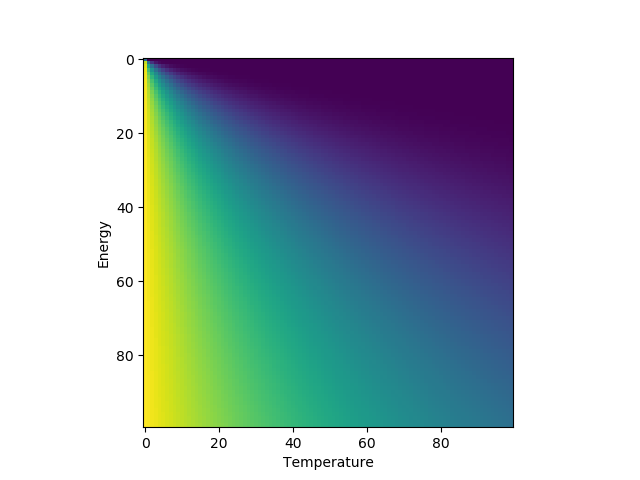

In [7]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Temperature')
ax.set_ylabel('Energy')
plt.imshow(boltz_mesh, interpolation='nearest')
plt.show()

## The Ising Model

A two-dimensional lattice is used to model a hypothetical surface.
Each entry in this lattice is either an up or down spin.
Spin interactions are only modeled along adjacent sites.

$$
\uparrow \quad \uparrow \quad \downarrow \quad \uparrow
$$

$$
\uparrow \quad \uparrow \quad \downarrow \quad \uparrow
$$

$$
\uparrow \quad \uparrow \quad \downarrow \quad \uparrow
$$

$$
\uparrow \quad \uparrow \quad \downarrow \quad \uparrow
$$

We have already stumbled upon a data structure that can hold this
array with `numpy.meshgrid`.

### Model Hamiltonian

$$
H_i = -J\sum_{j_{nn}}s_i s_j
$$

#### The $J$ Vlalue

The $J$ value represents how ferro- vs antiferro- magnetic materials are modeled.
If $J$ is positive it would mean that the material has a ferromagnetic 
nature (*parallel alignment*)
while a negative sign would imply that the material is antiferromagentic
(favours anti-parallel alignment)

Describing how we will calculate this Hamiltonian is better understood
by first modeling the array.

### Ising Model Array in Python

In [8]:
# Using +1 and -1 as possible values.
# Generate the array.
test_Ising_array = np.ones((4, 4))
print(test_Ising_array)

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]


In [9]:
# Select a point for reference. In this special
# case I will use 0.
test_Ising_array[1,1] = 0

# To identify the adjacent values we consider, I will set
# the adjacent values to -1.
test_Ising_array[1,0] = -1
test_Ising_array[0,1] = -1
test_Ising_array[2,1] = -1
test_Ising_array[1,2] = -1

print(test_Ising_array)

[[ 1. -1.  1.  1.]
 [-1.  0. -1.  1.]
 [ 1. -1.  1.  1.]
 [ 1.  1.  1.  1.]]


### Viewing the demo Ising Array 

<IPython.core.display.Javascript object>


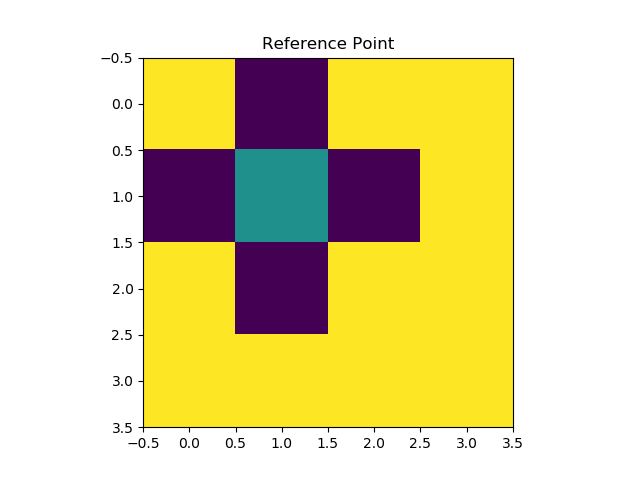

In [10]:
fig, ax = plt.subplots(1,1)
plt.imshow(test_Ising_array, interpolation='nearest')
ax.set_title("Reference Point")
plt.show()

## Defining a Fuction for the Hamiltonian

```
        A splice notation diagram is shown below.

         +---+---+---+---+---+---+
         | P | y | t | h | o | n |
         +---+---+---+---+---+---+
         0   1   2   3   4   5   6
        -6  -5  -4  -3  -2  -1
        ```

In [11]:
def calc_spin_flip_energy(ising_array, i, j, 
                          boundry_condition_function, 
                          magnetic_state=+1):
    """
    Calculate the energy, using a simplified Hamiltonian, of
    the current class instance array if the spin at index i, j
    is flipped.
    """
    s = len(ising_array)
    bcf = boundry_condition_function
    new_energy = magnetic_state * ising_array[i, j] * (
        ising_array[bcf(i - 1, s), j] +
        ising_array[bcf(i + 1, s), j] +
        ising_array[i, bcf(j - 1, s)] +
        ising_array[i, bcf(j + 1, s)]
    )

    return new_energy

def periodic_boundry(n, size):
    """
    Applies a periodic boundry condition on the given index,
    `n`, based on the given `size`.
    """
    # If the given index is on the right-most edge, return 0,
    # which is the beginning array index.
    if n + 1 >= size:
        return 0
    
    # If the given index is on the left-most edge, return the
    # size - 1, which is the right most edge index of the array.
    if n < 0:
        return size - 1
    
    # Otherwise return the given index unchanged.
    else:
        return n

In [12]:
len(test_Ising_array)

4

In [13]:
# Rebuilt the array with no zeroes.
test_Ising_array = np.ones((4, 4))
calc_spin_flip_energy(test_Ising_array, 1, 1 ,periodic_boundry)

4.0

## Defining a function to build a random starting array

The documentation from numpy concerning random numbers
is the ideal [place to start](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html).

In [14]:
def build_random_ising_array(size, seed=None):
    """
    Builds an array of size by size, filled with -1, or +1,
    as chosen by random.
    """
    
    # If a seed is provided, set the numpy random seed.
    if seed:
        np.random.seed(seed)
    
    # Create a new array with random values of either 0 or 1.
    # randint works by:
    # Return random integers from low (inclusive) to high (exclusive).
    new_ising_array = np.random.randint(0, 2, (size, size))
    
    # Now set all values that are 0 to -1.
    new_ising_array[new_ising_array == 0] = -1
    
    return new_ising_array

In [15]:
build_random_ising_array(10)

array([[-1, -1,  1, -1, -1, -1,  1, -1, -1, -1],
       [-1, -1,  1, -1, -1,  1, -1, -1,  1, -1],
       [-1, -1, -1,  1, -1, -1,  1, -1, -1, -1],
       [-1, -1,  1, -1,  1,  1,  1,  1, -1,  1],
       [ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1],
       [-1,  1,  1, -1, -1, -1,  1,  1,  1,  1],
       [ 1, -1,  1, -1, -1,  1,  1, -1,  1,  1],
       [ 1,  1, -1,  1, -1,  1,  1,  1, -1, -1],
       [ 1,  1, -1, -1, -1,  1, -1, -1, -1,  1],
       [-1,  1, -1,  1, -1,  1, -1,  1,  1, -1]])

<IPython.core.display.Javascript object>


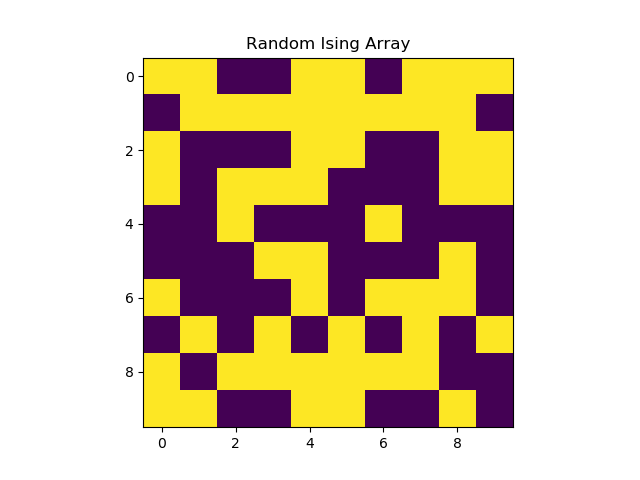

In [16]:
fig, ax = plt.subplots(1,1)
plt.imshow(build_random_ising_array(10), interpolation='nearest')
ax.set_title("Random Ising Array")
plt.show()

In [17]:
def run_ising_simulation(size, runs, temp=100):
    """
    Creates and simulates a matrix for the given number
    of runs.
    """
    
    # Create the array based on size.
    ising_array = build_random_ising_array(size)
    
    # Iterate over the runs.
    for run in range(runs):
        
        # Randomly select indicies in the array.
        r1, r2 = np.random.randint(0, size, 2)
        
        # Calculate the energy of the system if we flipped this spin.
        E_spin_flip = calc_spin_flip_energy(
            ising_array, 
            r1, 
            r2,
            periodic_boundry
        )
        
        # Call another random number to see if the spin is flipped.
        # If the energy is below 0, flip it.
        if E_spin_flip <= 0.0:
            ising_array[r1, r2] *= -1
            
        # Otherwise compare the probability of the calculated energy
        # to another random number between 0 and 1. If the calculated
        # is higher than the random number, flip the spin.
        elif calc_Boltz_Dist_Prob(energy=E_spin_flip, temperature=temp) > np.random.rand():
            ising_array[r1, r2] *= -1

    # Return the completed array.
    return ising_array

In [27]:
sim_1 = run_ising_simulation(size=100, runs=100000, temp=0.1)

## View the output matrix

<IPython.core.display.Javascript object>


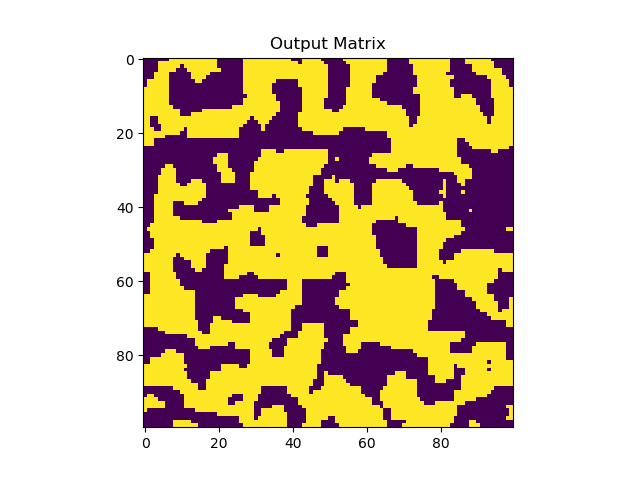

In [28]:
fig, ax = plt.subplots(1,1)
plt.imshow(sim_1, interpolation='nearest')
ax.set_title("Output Matrix")
plt.show()

## Drawn this onto a torus 

<IPython.core.display.Javascript object>


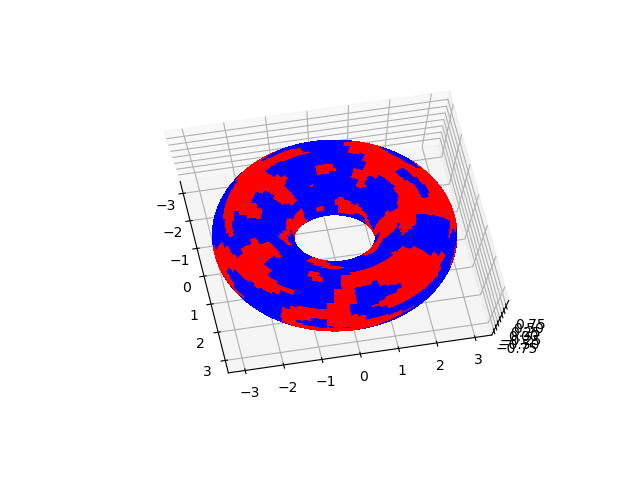

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')

n = 100

theta = np.linspace(0, 2.*np.pi, n)
phi = np.linspace(0, 2.*np.pi, n)
theta, phi = np.meshgrid(theta, phi)
c, a = 2, 1
X = (c + a*np.cos(theta)) * np.cos(phi)
Y = (c + a*np.cos(theta)) * np.sin(phi)
Z = a * np.sin(theta)

# Create an empty array of strings with the same shape as the meshgrid, and
# populate it with two colors in a checkerboard pattern.
colorDict = {
    -1: 'r',
    1 : 'b'
}
colors = np.empty(sim_1.shape, dtype=str)
for y in range(len(sim_1)):
    for x in range(len(sim_1)):
        colors[x, y] = colorDict[sim_1[x, y]]

surf = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1,
    facecolors=colors,
    linewidth=0, antialiased=False, shade=False)
